In [60]:
import pandas as pd
from pmdarima import auto_arima
from pmdarima.model_selection import train_test_split
import matplotlib.pyplot  as plt
import numpy as np
import pmdarima as pm
from pmdarima.arima import ARIMA
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import datetime
import requests
import warnings
import matplotlib
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings("ignore")

df = pd.read_csv('multivariate_eng_df.csv', index_col = 'Date', parse_dates = True)
df.head()

,STATE,PROVINCE_STATE_NAME,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_12Plus,Administered_Dose1_Recip_18Plus,Administered_Dose1_Recip_65Plus,Series_Complete_Yes,Series_Complete_5Plus,...,vaccination_rate_complete,booster_rate,prop_age04,prop_age59,prop_age6064,prop_age8084,prop_age85plus,AGE04_29_TOT,AGE30_59_TOT,AGE60PLUS_TOT
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2020-03-02,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2020-03-03,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2020-03-04,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2020-03-05,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914


In [61]:
#separate df for california -- multivariate still
ca_df = df.loc[df['PROVINCE_STATE_NAME'] == 'California']

In [62]:
#separate univariate dataframe for california
ca_uni_df = ca_df[['PEOPLE_POSITIVE_NEW_CASES_COUNT']]

In [63]:
#separate train & test sets
train_size = int(len(ca_uni_df)* 0.8)
ca_uni_train, ca_uni_test = ca_uni_df[0:train_size], ca_uni_df[train_size:]

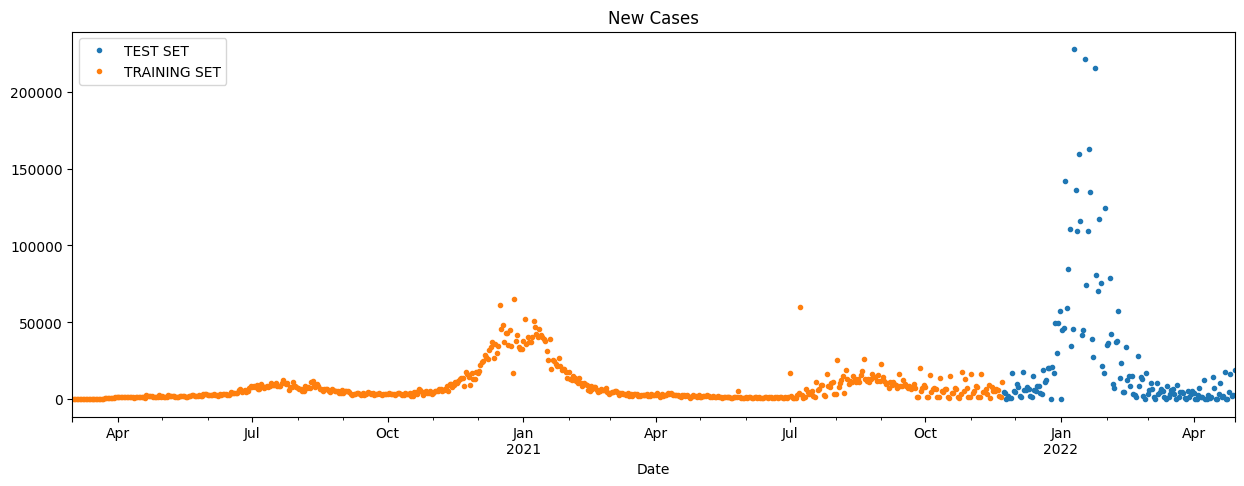

In [64]:
#visualize the 80/20 train/test split
ca_uni_test \
    .rename(columns={'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'TEST SET'}) \
    .join(ca_uni_train.rename(columns={'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'TRAINING SET'}), how='outer')

_ = ca_uni_test \
    .rename(columns={'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'TEST SET'}) \
    .join(ca_uni_train.rename(columns={'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='New Cases', style='.')

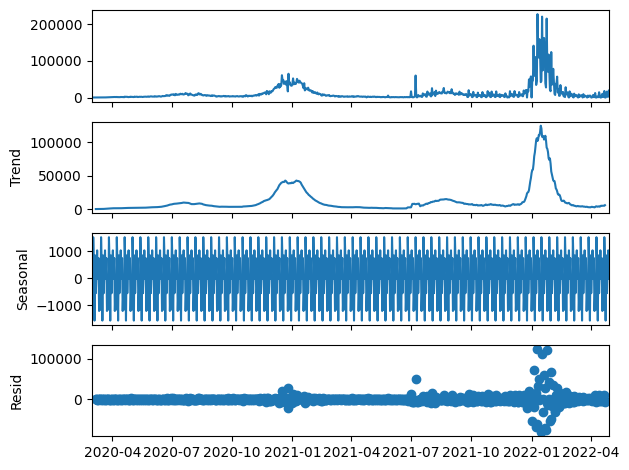

In [65]:
#time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(ca_uni_df, period=12).plot()

plt.show()

In [75]:
#baseline seasonal arima model
import statsmodels.api as sm

sarimax = sm.tsa.statespace.SARIMAX(ca_uni_train, order = (1, 1, 1),seasonal_order=(1,1,1,7))
seasonal_model = sarimax.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75665D+00    |proj g|=  6.54836D-02

At iterate    5    f=  9.69748D+00    |proj g|=  2.06333D-02

At iterate   10    f=  9.69408D+00    |proj g|=  3.10696D-04


 This problem is unconstrained.



At iterate   15    f=  9.69408D+00    |proj g|=  5.17538D-04

At iterate   20    f=  9.69381D+00    |proj g|=  6.84025D-03

At iterate   25    f=  9.67559D+00    |proj g|=  3.56390D-02

At iterate   30    f=  9.64369D+00    |proj g|=  1.44981D-03

At iterate   35    f=  9.64195D+00    |proj g|=  2.13746D-02

At iterate   40    f=  9.64072D+00    |proj g|=  4.79837D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     47      1     0     0   1.669D-05   9.641D+00
  F =   9.6407232004375487     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<Axes: xlabel='Date'>

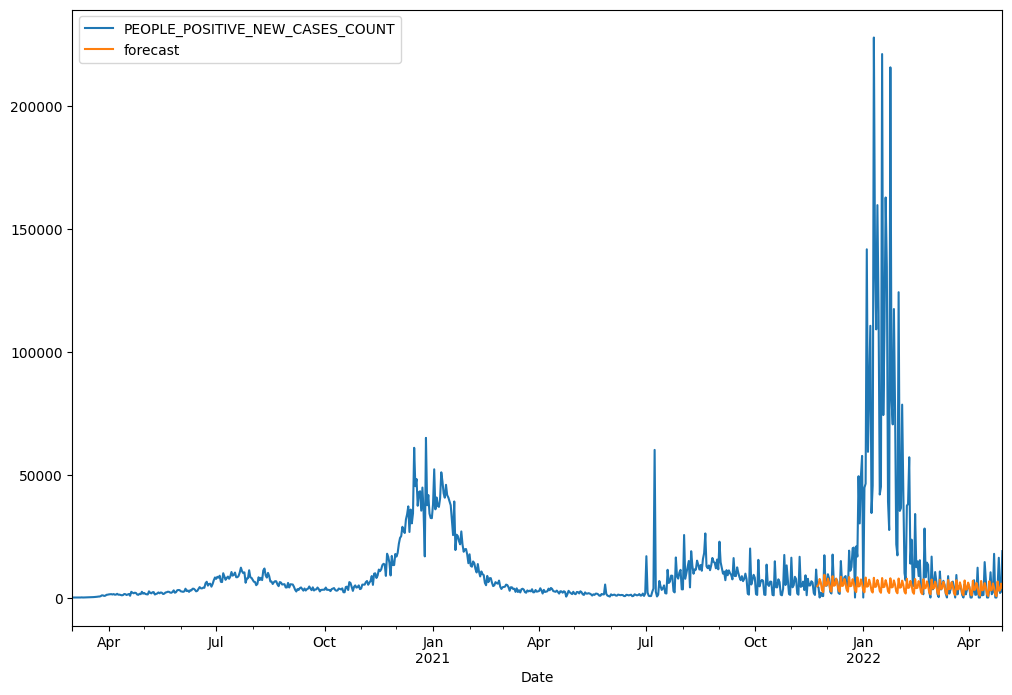

In [76]:
ca_uni_df['forecast']=seasonal_model.predict(start=632,end=790,dynamic=True)
ca_uni_df[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast']].plot(figsize=(12,8))

<Axes: title={'center': 'SARIMA Predictions vs. True Values'}, xlabel='Date'>

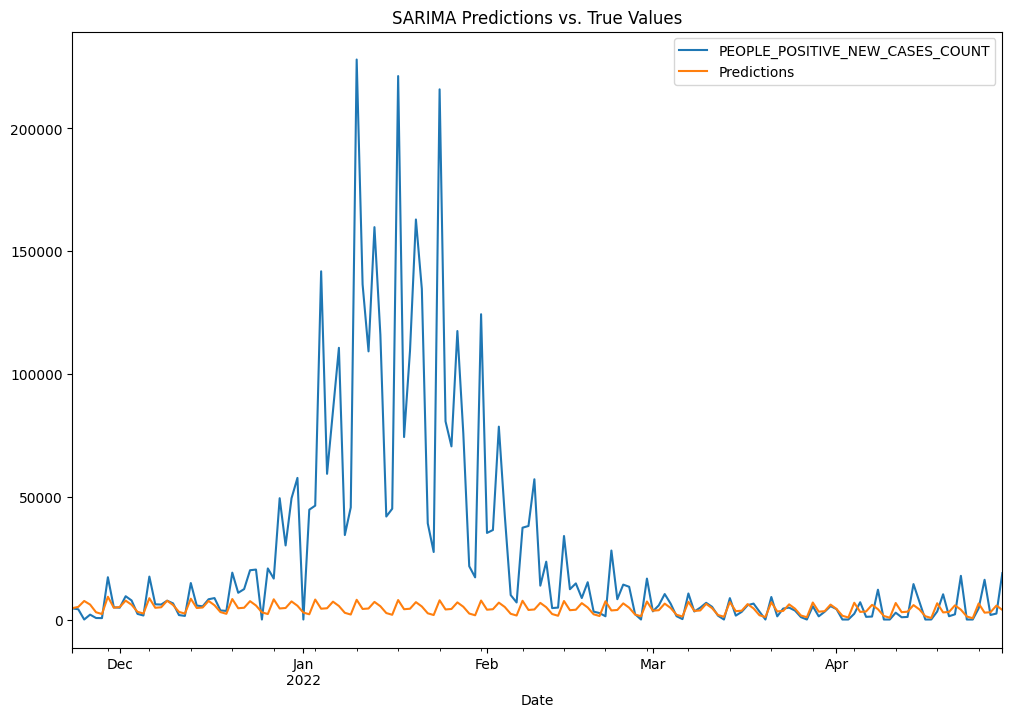

In [77]:
ca_uni_test['Predictions']=seasonal_model.predict(start=632,end=790,dynamic=True)
ca_uni_test[['PEOPLE_POSITIVE_NEW_CASES_COUNT','Predictions']].plot(figsize=(12,8), title='SARIMA Predictions vs. True Values')


In [78]:
#identification -- determine values of p & q
#use gridsearch to select values of p and q -- AIC performance metric
warnings.filterwarnings("ignore")
results=[]
for p in range(1,3):
    for q in range(1,3):
        for P in range(1,3):
            for Q in range(1,3):
                print(p,q,P,Q)
                model=sm.tsa.statespace.SARIMAX(ca_uni_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'],order=(p,1,q), seasonal_order=(P,1,Q,7)).fit()
                results.append([p,q,P,Q,model.aic])  
                
# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic') 

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75665D+00    |proj g|=  6.54836D-02

At iterate    5    f=  9.69748D+00    |proj g|=  2.06333D-02


 This problem is unconstrained.



At iterate   10    f=  9.69408D+00    |proj g|=  3.10696D-04

At iterate   15    f=  9.69408D+00    |proj g|=  5.17538D-04

At iterate   20    f=  9.69381D+00    |proj g|=  6.84025D-03

At iterate   25    f=  9.67559D+00    |proj g|=  3.56390D-02

At iterate   30    f=  9.64369D+00    |proj g|=  1.44981D-03

At iterate   35    f=  9.64195D+00    |proj g|=  2.13746D-02

At iterate   40    f=  9.64072D+00    |proj g|=  4.79837D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     47      1     0     0   1.669D-05   9.641D+00
  F =   9.6407232004375487     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  9.69549D+00    |proj g|=  4.98782D-03

At iterate   10    f=  9.69374D+00    |proj g|=  2.04543D-02

At iterate   15    f=  9.69299D+00    |proj g|=  8.80771D-05

At iterate   20    f=  9.69298D+00    |proj g|=  7.25448D-04

At iterate   25    f=  9.69233D+00    |proj g|=  8.90138D-03

At iterate   30    f=  9.67104D+00    |proj g|=  6.61730D-02

At iterate   35    f=  9.66068D+00    |proj g|=  5.85011D-03

At iterate   40    f=  9.65640D+00    |proj g|=  5.94181D-02

At iterate   45    f=  9.64613D+00    |proj g|=  8.61740D-03

At iterate   50    f=  9.64609D+00    |proj g|=  9.64953D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  9.69332D+00    |proj g|=  3.24279D-03

At iterate   15    f=  9.69320D+00    |proj g|=  7.28392D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     17      1     0     0   7.284D-05   9.693D+00
  F =   9.6931983619100297     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.71875D+00    |proj g|=  5.01577D-02


 This problem is unconstrained.



At iterate    5    f=  9.69385D+00    |proj g|=  6.15304D-03

At iterate   10    f=  9.69356D+00    |proj g|=  9.10187D-04

At iterate   15    f=  9.69325D+00    |proj g|=  6.88035D-03

At iterate   20    f=  9.69299D+00    |proj g|=  1.08560D-03

At iterate   25    f=  9.69298D+00    |proj g|=  7.29187D-05

At iterate   30    f=  9.69297D+00    |proj g|=  2.55092D-03

At iterate   35    f=  9.69134D+00    |proj g|=  2.18033D-02

At iterate   40    f=  9.64388D+00    |proj g|=  8.48583D-03

At iterate   45    f=  9.64113D+00    |proj g|=  8.64051D-04

At iterate   50    f=  9.64086D+00    |proj g|=  8.01851D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  9.67518D+00    |proj g|=  5.20736D-04

At iterate   15    f=  9.67507D+00    |proj g|=  1.70680D-03

At iterate   20    f=  9.67493D+00    |proj g|=  3.55949D-04

At iterate   25    f=  9.67484D+00    |proj g|=  8.86673D-03

At iterate   30    f=  9.67430D+00    |proj g|=  9.93921D-04

At iterate   35    f=  9.67424D+00    |proj g|=  6.53024D-05

At iterate   40    f=  9.67422D+00    |proj g|=  1.27659D-03

At iterate   45    f=  9.67296D+00    |proj g|=  1.75599D-02

At iterate   50    f=  9.66902D+00    |proj g|=  8.39504D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64   

 This problem is unconstrained.



At iterate    5    f=  9.67696D+00    |proj g|=  5.88148D-03

At iterate   10    f=  9.67456D+00    |proj g|=  1.10500D-02

At iterate   15    f=  9.67423D+00    |proj g|=  4.98582D-04

At iterate   20    f=  9.67382D+00    |proj g|=  3.75024D-03

At iterate   25    f=  9.67232D+00    |proj g|=  2.25277D-03

At iterate   30    f=  9.67212D+00    |proj g|=  2.94641D-04

At iterate   35    f=  9.67212D+00    |proj g|=  4.63576D-04

At iterate   40    f=  9.67180D+00    |proj g|=  1.34445D-02

At iterate   45    f=  9.65458D+00    |proj g|=  7.39800D-02

At iterate   50    f=  9.64465D+00    |proj g|=  1.62507D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.69228D+00    |proj g|=  3.73830D-02

At iterate   10    f=  9.67474D+00    |proj g|=  7.11076D-03

At iterate   15    f=  9.67438D+00    |proj g|=  4.98388D-04

At iterate   20    f=  9.67394D+00    |proj g|=  8.12318D-03

At iterate   25    f=  9.67252D+00    |proj g|=  3.82083D-03

At iterate   30    f=  9.67194D+00    |proj g|=  3.50580D-04

At iterate   35    f=  9.67194D+00    |proj g|=  6.93987D-05

At iterate   40    f=  9.67192D+00    |proj g|=  2.02355D-03

At iterate   45    f=  9.67007D+00    |proj g|=  1.04645D-02

At iterate   50    f=  9.65670D+00    |proj g|=  1.50243D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.67586D+00    |proj g|=  1.39039D-02

At iterate   10    f=  9.67505D+00    |proj g|=  8.92655D-04

At iterate   15    f=  9.67454D+00    |proj g|=  1.57822D-02

At iterate   20    f=  9.67361D+00    |proj g|=  3.39877D-03

At iterate   25    f=  9.67328D+00    |proj g|=  3.58789D-03

At iterate   30    f=  9.67282D+00    |proj g|=  2.90412D-03

At iterate   35    f=  9.67276D+00    |proj g|=  3.45443D-04

At iterate   40    f=  9.67276D+00    |proj g|=  2.37629D-04

At iterate   45    f=  9.67254D+00    |proj g|=  9.58594D-03

At iterate   50    f=  9.67170D+00    |proj g|=  1.58236D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.69523D+00    |proj g|=  1.09089D-02

At iterate   10    f=  9.69369D+00    |proj g|=  1.34216D-03

At iterate   15    f=  9.69369D+00    |proj g|=  7.25635D-05

At iterate   20    f=  9.69365D+00    |proj g|=  2.06584D-03

At iterate   25    f=  9.68429D+00    |proj g|=  6.38521D-02

At iterate   30    f=  9.64074D+00    |proj g|=  6.73247D-03

At iterate   35    f=  9.64036D+00    |proj g|=  4.80060D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     43      1     0     0   8.132D-06   9.640D+00
  F =   9.6403567076713390     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  9.69488D+00    |proj g|=  7.19571D-03

At iterate   10    f=  9.69322D+00    |proj g|=  8.56758D-03

At iterate   15    f=  9.69261D+00    |proj g|=  1.57531D-04

At iterate   20    f=  9.69261D+00    |proj g|=  1.61116D-04

At iterate   25    f=  9.69256D+00    |proj g|=  3.92357D-03

At iterate   30    f=  9.68774D+00    |proj g|=  4.74058D-02

At iterate   35    f=  9.65412D+00    |proj g|=  3.05173D-02

At iterate   40    f=  9.64094D+00    |proj g|=  1.07873D-02

At iterate   45    f=  9.63866D+00    |proj g|=  7.28937D-04

At iterate   50    f=  9.63866D+00    |proj g|=  5.48917D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.70867D+00    |proj g|=  5.62278D-02

At iterate   10    f=  9.69287D+00    |proj g|=  6.91777D-03

At iterate   15    f=  9.69279D+00    |proj g|=  7.28646D-05

At iterate   20    f=  9.69279D+00    |proj g|=  5.82543D-04

At iterate   25    f=  9.69144D+00    |proj g|=  1.11247D-02

At iterate   30    f=  9.64471D+00    |proj g|=  4.32443D-02

At iterate   35    f=  9.63902D+00    |proj g|=  8.82263D-04

At iterate   40    f=  9.63897D+00    |proj g|=  7.68960D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     46      1     0     0   1.126D-05   9.639D+00
  F =   9.63896499451

 This problem is unconstrained.



At iterate    5    f=  9.69352D+00    |proj g|=  8.27933D-03

At iterate   10    f=  9.69320D+00    |proj g|=  1.03346D-03

At iterate   15    f=  9.69288D+00    |proj g|=  3.91063D-03

At iterate   20    f=  9.69260D+00    |proj g|=  1.89384D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     22     27      1     0     0   7.293D-05   9.693D+00
  F =   9.6926024609786836     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  9.70093D+00    |proj g|=  5.66005D-02

At iterate   10    f=  9.67218D+00    |proj g|=  9.84581D-03

At iterate   15    f=  9.67177D+00    |proj g|=  1.27610D-04

At iterate   20    f=  9.67176D+00    |proj g|=  2.87731D-03

At iterate   25    f=  9.67155D+00    |proj g|=  8.94049D-03

At iterate   30    f=  9.67026D+00    |proj g|=  5.32539D-03

At iterate   35    f=  9.66957D+00    |proj g|=  2.02653D-03

At iterate   40    f=  9.66838D+00    |proj g|=  2.12201D-03

At iterate   45    f=  9.66830D+00    |proj g|=  1.05599D-03

At iterate   50    f=  9.66829D+00    |proj g|=  6.26079D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.67483D+00    |proj g|=  1.81902D-02

At iterate   10    f=  9.67288D+00    |proj g|=  8.60152D-03

At iterate   15    f=  9.67055D+00    |proj g|=  8.20913D-04

At iterate   20    f=  9.67055D+00    |proj g|=  1.89929D-04

At iterate   25    f=  9.67051D+00    |proj g|=  4.36880D-03

At iterate   30    f=  9.67023D+00    |proj g|=  6.32835D-03

At iterate   35    f=  9.66939D+00    |proj g|=  7.47129D-03

At iterate   40    f=  9.66769D+00    |proj g|=  1.13241D-02

At iterate   45    f=  9.66660D+00    |proj g|=  2.45128D-03

At iterate   50    f=  9.66628D+00    |proj g|=  4.31189D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.70907D+00    |proj g|=  4.07025D-02

At iterate   10    f=  9.67318D+00    |proj g|=  2.39273D-02

At iterate   15    f=  9.67077D+00    |proj g|=  1.66206D-04

At iterate   20    f=  9.67074D+00    |proj g|=  1.79669D-03

At iterate   25    f=  9.67034D+00    |proj g|=  1.36118D-02

At iterate   30    f=  9.66929D+00    |proj g|=  9.89261D-03

At iterate   35    f=  9.66741D+00    |proj g|=  1.01699D-02

At iterate   40    f=  9.66623D+00    |proj g|=  2.49395D-03

At iterate   45    f=  9.66614D+00    |proj g|=  6.33039D-05

At iterate   50    f=  9.66613D+00    |proj g|=  6.14792D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.67740D+00    |proj g|=  2.78660D-02

At iterate   10    f=  9.67127D+00    |proj g|=  2.29451D-03

At iterate   15    f=  9.67118D+00    |proj g|=  3.87446D-03

At iterate   20    f=  9.67057D+00    |proj g|=  5.84079D-03

At iterate   25    f=  9.67051D+00    |proj g|=  4.14504D-04

At iterate   30    f=  9.67050D+00    |proj g|=  1.73057D-03

At iterate   35    f=  9.67008D+00    |proj g|=  1.16731D-02

At iterate   40    f=  9.66901D+00    |proj g|=  7.26373D-03

At iterate   45    f=  9.66755D+00    |proj g|=  4.64927D-03

At iterate   50    f=  9.66615D+00    |proj g|=  4.01991D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [79]:
df_results

,p,q,P,Q,aic
0,1,1,1,1,12195.874125
9,2,1,1,2,12197.260015
8,2,1,1,1,12197.410878
10,2,1,2,1,12197.651753
3,1,1,2,2,12200.050301
1,1,1,1,2,12204.655807
5,1,2,1,2,12204.843216
6,1,2,2,1,12220.074683
4,1,2,1,1,12233.645421
14,2,2,2,1,12233.991053


In [81]:
#optimal SARIMA model revealed via gridsearch with AIC for performance evaluation
#train model
sarimax_1=sm.tsa.statespace.SARIMAX(ca_uni_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'],order=(1,1,1), seasonal_order=(1,1,1,7)).fit()

#make predictions
predictions_1 = sarimax_1.predict(start=632,end=789,dynamic=True)

#calculate performance metrics
mae = mean_absolute_error(ca_uni_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'], predictions_1)
mse = mean_squared_error(ca_uni_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'], predictions_1)
rmse = np.sqrt(mse)

#naive forecast for mase calculation
naive_forecast = ca_uni_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'].shift(1)
#mae of the naive forecast (excluding first NaN value)
mae_naive = mean_absolute_error(ca_uni_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'][1:], naive_forecast.dropna())
mase = mae / mae_naive

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Percent Error: {mape}')
print(f'Mean Absolute Scaled Error: {mase}')

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75665D+00    |proj g|=  6.54836D-02

At iterate    5    f=  9.69748D+00    |proj g|=  2.06333D-02

At iterate   10    f=  9.69408D+00    |proj g|=  3.10696D-04

At iterate   15    f=  9.69408D+00    |proj g|=  5.17538D-04

At iterate   20    f=  9.69381D+00    |proj g|=  6.84025D-03

At iterate   25    f=  9.67559D+00    |proj g|=  3.56390D-02

At iterate   30    f=  9.64369D+00    |proj g|=  1.44981D-03

At iterate   35    f=  9.64195D+00    |proj g|=  2.13746D-02

At iterate   40    f=  9.64072D+00    |proj g|=  4.79837D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 